# Solving Sudoku using Grover's Algorithm

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, ClassicalRegister, QuantumRegister
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


The oracles used throughout this chapter so far have been created with prior knowledge of their solutions. We will now solve a simple problem using Grover's algorithm, for which we do not necessarily know the solution beforehand. Our problem is a 2×2 binary sudoku, which in our case has two simple rules:

* No column may contain the same value twice
* No row may contain the same value twice

If we assign each square in our sudoku to a variable like so:

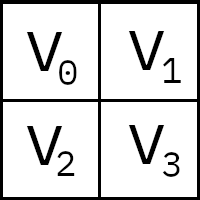

we want our circuit to output a solution to this sudoku.

# Turning the Problem into a Circuit

To create the oracle, we simply need to create a classical circuit that checks whether the state of our variable bits is a valid solution. Since we need to check down both columns and across both rows, there are 4 conditions we need to check:


v0 ≠ v1   # check along top row

v2 ≠ v3   # check along bottom row

v0 ≠ v2   # check down left column

v1 ≠ v3   # check down right column


Remember we are comparing classical (computational basis) states. For convenience, we can compile this set of comparisons into a list of clauses:

In [2]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

To check these clauses computationally, we will use the XOR gate (we came across this in the atoms of computation)

In [3]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

Convince yourself that the output0 bit in the circuit below will only be flipped if input0 ≠ input1:

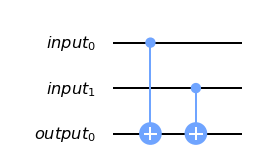

In [4]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

To check each clause, we repeat this circuit for each pairing in clause_list and store the output to a new bit:

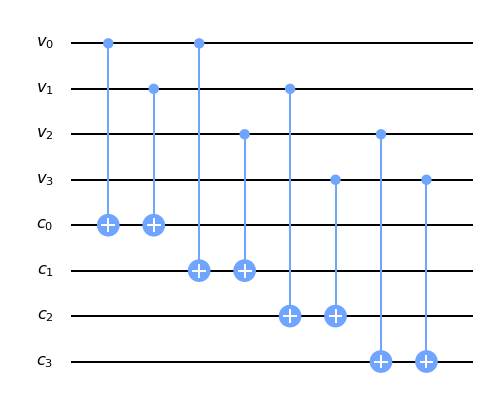

In [5]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

The final state of the bits c0, c1, c2, c3 will only all be 1 in the case that the assignments of v0, v1, v2, v3 are a solution to the sudoku. To complete our checking circuit, we want a single bit to be 1 if (and only if) all the clauses are satisfied, this way we can look at just one bit to see if our assignment is a solution. We can do this using a multi-controlled-Toffoli-gate:

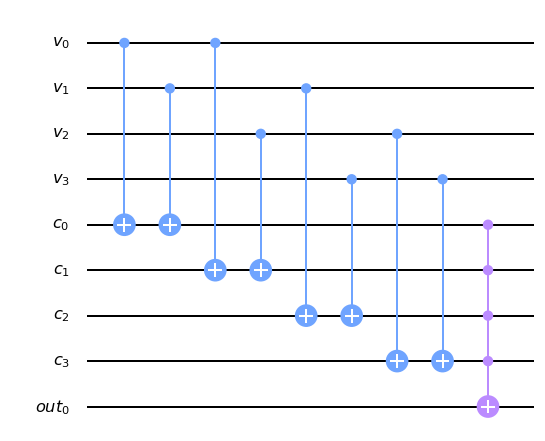

In [6]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

We can now turn this checking circuit into a Grover oracle using phase kickback. 
To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (c) are always returned to the state |0000⟩ after the computation. To do this, we simply repeat the part of the circuit that computes the clauses which guarantees c0 = c1 = c2 = c3 = 0 after our circuit has run. We call this step 'uncomputation'.

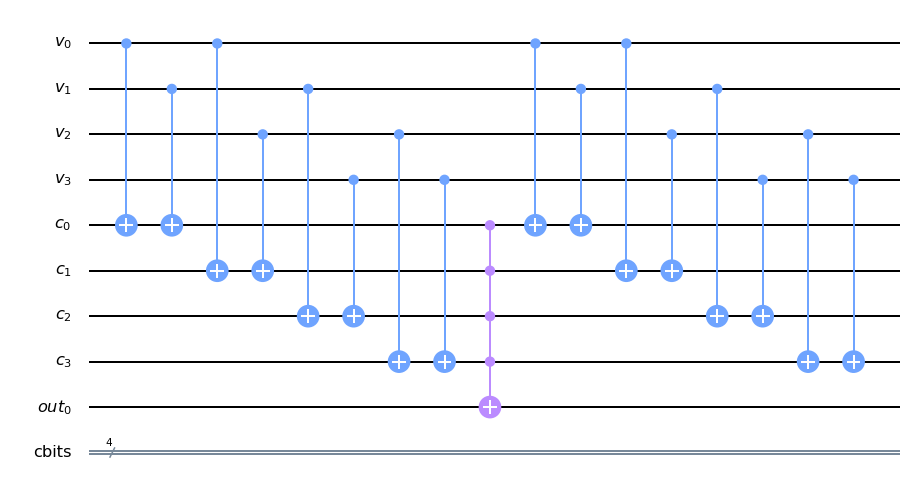

In [7]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.draw()

If we set the out0 qubit to the superposition state |−⟩ and if we don't match the solution then the otput remains unchanged otherwise it flips it's phase

# Details: Creating a General Diffuser 


In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "$U_s$"
    return U_s

# The Full Algorithm

All that's left to do now is to put this oracle into Grover's algorithm!

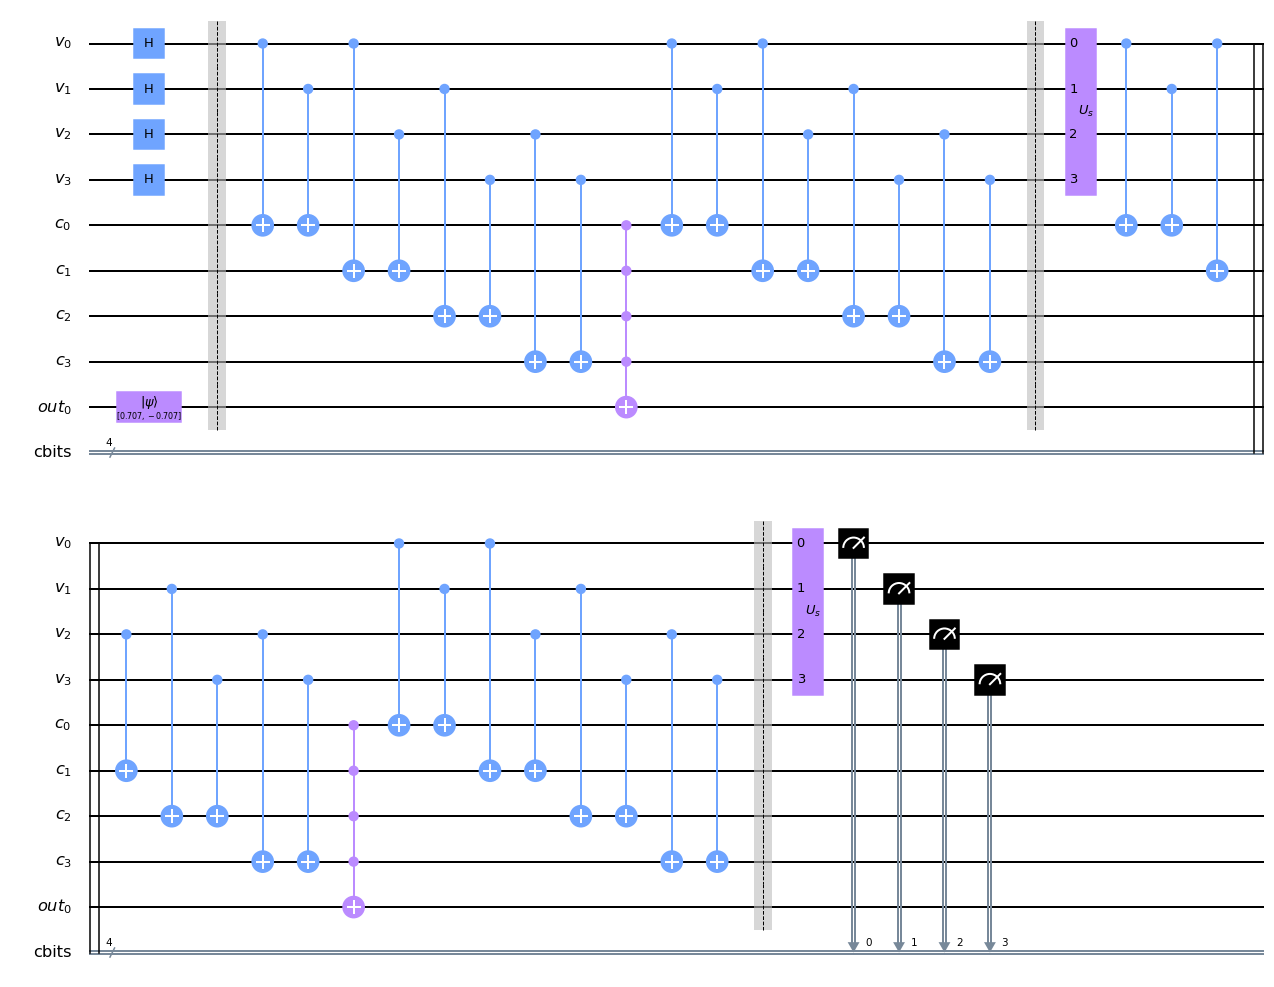

In [9]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialise 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialise qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, var_qubits, clause_qubits, cbits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw()

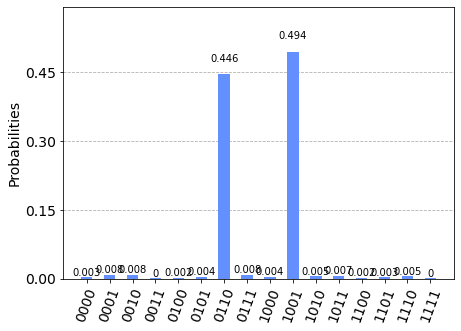

In [10]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, backend=qasm_simulator, shots=1024).result()
plot_histogram(result.get_counts())


There are two bit strings with a much higher probability of measurement than any of the others, 0110 and 1001. These correspond to the assignments:

v0 = 0
v1 = 1
v2 = 1
v3 = 0

and

v0 = 1
v1 = 0
v2 = 0
v3 = 1